In [1]:
import tensorflow as tf
from time import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import mlutils
import importlib
importlib.reload(mlutils)

/home/gabriel24/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


<module 'mlutils' from '/home/gabriel24/20191.DL/mlutils.py'>

# Lab: Convolutional network with TensorFlow low level API


### RECOMMENDATION

- close all applications
- install Maxthon browser http://www.maxthon.com
- open only VirtualBox and Maxthon


**Using a small dataset based on [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html)**


In [2]:
!wget -nc https://s3.amazonaws.com/rlx/mini_cifar.h5
import h5py
with h5py.File('mini_cifar.h5','r') as h5f:
    x_cifar = h5f["x"][:]
    y_cifar = h5f["y"][:]

El fichero “mini_cifar.h5” ya está ahí, no se recupera.



In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
x_train, x_test, y_train, y_test = train_test_split(x_cifar, y_cifar, test_size=.25)
print (x_train.shape, y_train.shape, x_test.shape, y_test.shape)
print ("\ndistribution of train classes")
print (pd.Series(y_train).value_counts())
print ("\ndistribution of test classes")
print (pd.Series(y_test).value_counts())


(2253, 32, 32, 3) (2253,) (751, 32, 32, 3) (751,)

distribution of train classes
2    789
0    742
1    722
dtype: int64

distribution of test classes
0    263
1    252
2    236
dtype: int64


In [4]:
y__=pd.Series(y_train)
y_train_tidy=pd.get_dummies(y__)
y_test_tidy=pd.Series(y_test)
y_test_tidy=pd.get_dummies(y_test_tidy)
y_train_tidy.tail()




,0,1,2
2248,0,0,1
2249,0,0,1
2250,1,0,0
2251,0,1,0
2252,0,1,0


# Part 1: Build a CNN with TF Low Level API

### Build the convolutional network model

with the same architecture as in the corresponding notebook:

    Layer (type)                 Output Shape              Param #   
    =================================================================
    input_1 (InputLayer)         (None, 32, 32, 3)         0         
    _________________________________________________________________
    conv2d (Conv2D)              (None, 32, 32, 15)        735       
    _________________________________________________________________
    flatten (Flatten)            (None, 15360)             0         
    _________________________________________________________________
    dense (Dense)                (None, 16)                245776    
    _________________________________________________________________
    output_1 (Dense)             (None, 3)                 51        
    =================================================================
    Total params: 246,562
    Trainable params: 246,562
    Non-trainable params: 0
    _________________________________________________________________

#### understand carefully the example [here](http://www.jessicayung.com/explaining-tensorflow-code-for-a-convolutional-neural-network/). 

Complete the following function. You will have to:

1. Declare tensor symbolic variables for inputs and model parameters:

    - Define placefolders for X and y
    - Define tf variables for W's and b's. You will have to think carefully about their shapes.


2. Build the computational graph

    - Use [tf.random_normal](https://www.tensorflow.org/api_docs/python/tf/random/normal) with mean 0 and std 1 as initialization distribuition for all W's and b's
    - Use [tf.nn.conv2d](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d) for the convolutional layer (`h_conv1`)
    - Use [tf.reshape](https://www.tensorflow.org/api_docs/python/tf/reshape) to transition from the convolutional layer to the dense layer (`h_conv1_flat`)
    - Model the dense layer with TF matrix multiplication and relu activation (`h_dense`)
    - Model the output with three output neurons and softmax activation (`y_proba`)

the shapes of the weights your define must be equal to the ones printed out in the corresponding notebook.




In [5]:
def multiply(n): 
    total = 1 
    for i in range(1, len(n)):
        total *= n[i]
    return total 
output_units=len(np.unique(y_cifar))
print(output_units)

3


In [6]:
def build_model(n_filters, filter_size, dense_size, img_size, n_channels):

    init_stddev = 0.01    
    tf.reset_default_graph()    
    tX = tf.placeholder(name="X", dtype=tf.float64, shape = (None,img_size,img_size,n_channels))
    ty = tf.placeholder(name="y", dtype=tf.int32, shape = (None,len(np.unique(y_cifar))))
    #ty1 = tf.placeholder(name="y", dtype=tf.int32, shape = (None,1))    
    w_conv1 = tf.Variable(initial_value=tf.random_normal([filter_size,filter_size,n_channels,n_filters],dtype=tf.float64,mean=0,stddev=1,),name='W1',dtype=tf.float64)
    b_conv1 = tf.Variable(initial_value=tf.random_normal([n_filters],mean=0,stddev=1,dtype=tf.float64), name="b1", dtype=tf.float64)

    w_dense = tf.Variable(initial_value=tf.random_normal([n_filters*(img_size)*img_size,dense_size],mean=0,stddev=1,dtype=tf.float64),name='W2',dtype=tf.float64)

    b_dense = tf.Variable(initial_value=tf.random_normal([dense_size],mean=0,stddev=1,dtype=tf.float64), name="b2", dtype=tf.float64)


    w_out   = tf.Variable(initial_value=tf.random_normal([dense_size,output_units],mean=0,stddev=1,dtype=tf.float64),name='W3',dtype=tf.float64)

    b_out   = tf.Variable(initial_value=tf.random_normal([output_units],mean=0,stddev=1,dtype=tf.float64), name="b3", dtype=tf.float64)


    


    with tf.name_scope("cnn"):
        h_conv1      = tf.nn.conv2d(tX,w_conv1,strides=[1, 1, 1, 1], padding='SAME')
        h_conv1      = tf.nn.bias_add(h_conv1, b_conv1)
        h_conv1      = tf.nn.relu(h_conv1)
        h_conv1_flat = tf.reshape(h_conv1,(-1,multiply(h_conv1.get_shape().as_list())))
        h_dense      = tf.add(tf.matmul(h_conv1_flat, w_dense), b_dense)
        h_dense      = tf.nn.relu(h_dense)        
        y_proba      = tf.add(tf.matmul(h_dense, w_out), b_out)
        y_proba      = tf.nn.softmax(y_proba)
        y_proba      = tf.cast(y_proba, tf.float32)
        print(y_proba.shape)
        print(ty.shape)

    with tf.name_scope("cross_entropy"):
        y_hat        = tf.argmax(y_proba, axis=1)
        xentropy     = tf.nn.softmax_cross_entropy_with_logits_v2(logits=y_proba, labels=ty)

    with tf.name_scope("optimization"):
        loss         = tf.reduce_mean(xentropy)
        optimizer    = tf.train.AdamOptimizer()
        training_op  = optimizer.minimize(loss)

    with tf.name_scope("eval"):
        y_proba2=tf.reshape(y_proba,shape=(-1,1))
        ty1=tf.reshape(ty,shape=(3,-1))
        correct = tf.nn.in_top_k(y_proba,ty1[0],1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

    with tf.name_scope("init_and_save"):
        init = tf.global_variables_initializer()

    print ("-- weights shape --")
    print (w_conv1.shape)
    print (b_conv1.shape)
    print (w_dense.shape)
    print (b_dense.shape)
    print (w_out.shape)
    print (b_out.shape) 

    return tX, ty, init, accuracy, training_op, loss,ty1

In [7]:
n_classes = len(np.unique(y_cifar))
print ("using", n_classes, "classes")

n_filters   = 15
filter_size = 4
dense_size  = 16
n_channels  = 3 
img_size    = 32

n_epochs = 30
batch_size = 20


using 3 classes


In [8]:
tX, ty, init, accuracy, training_op, loss ,ty1= build_model(n_filters, filter_size, dense_size, img_size, n_channels)

Instructions for updating:
Colocations handled automatically by placer.
(?, 3)
(?, 3)
-- weights shape --
(4, 4, 3, 15)
(15,)
(15360, 16)
(16,)
(16, 3)
(3,)


## Create the optimization loop

keep track of accuracy and loss in both train and test. Base your implementation on the notebook describing TF low level API.

Observe that accuracy must keep one metric per epoch averaging the accuracy obtained in all batches. Likewise for loss.

Plot the accuracy and loss curves for test and train separately, which should look like the following

![](Images/lab_batch_01.png)



In [9]:
y_train[:10]

array([2, 1, 2, 1, 0, 0, 0, 0, 1, 0])

In [11]:

loss_hist = []
num_examples = len(x_train)
acc_train, acc_test = [], []
loss_train, loss_test = [], []

with tf.Session() as sess:
    sess.run(init)

    
    for i in mlutils.pbar()(range(1,n_epochs)):
        ixds = np.random.permutation(len(x_train))
        ixds2 = np.random.permutation(len(x_test))
        __, _eloss= sess.run([training_op, loss], feed_dict={tX: x_train[ixds], ty: y_train_tidy.iloc[ixds]})
        _tloss = sess.run([loss], feed_dict={tX: x_test[ixds2], ty: y_test_tidy.iloc[ixds2]})
        _tacc =sess.run(accuracy,feed_dict={tX: x_test[ixds2], ty: y_test_tidy.iloc[ixds2]})
        _eacc =sess.run(accuracy,feed_dict={tX: x_train[ixds], ty: y_train_tidy.iloc[ixds]})

        loss_train.append(_eloss)
        loss_test.append(_tloss)
        acc_train.append(_eacc)
        acc_test.append(_tacc)
        
    #val_W1, val_W2, val_b1, val_b2 = sess.run([tW1, tW2, tb1, tb2])

100% |########################################################################|


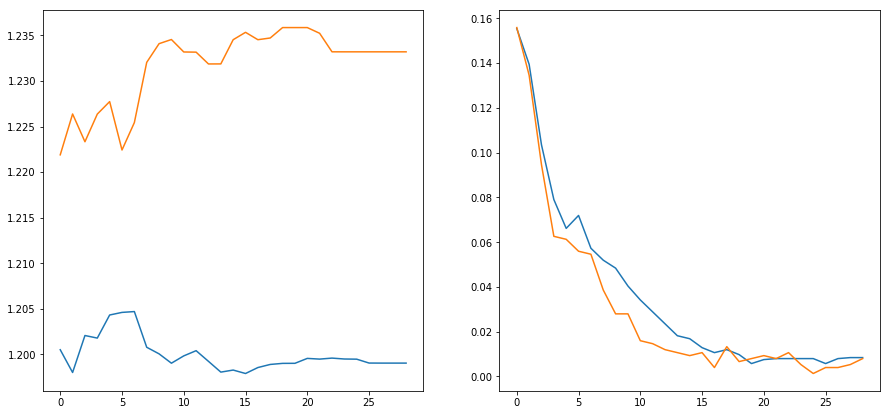

In [14]:
plt.figure(figsize=(15,7))
plt.subplot(121)
plt.plot(loss_train)
plt.plot(loss_test)
plt.subplot(122)
plt.plot(acc_train)
plt.plot(acc_test)

    

In [13]:
acc_test

[0.15579228,
 0.13448735,
 0.09454061,
 0.06258322,
 0.061251663,
 0.055925433,
 0.054593876,
 0.03861518,
 0.027962716,
 0.027962716,
 0.015978696,
 0.014647137,
 0.011984021,
 0.010652463,
 0.009320905,
 0.010652463,
 0.003994674,
 0.013315579,
 0.0066577895,
 0.007989348,
 0.009320905,
 0.007989348,
 0.010652463,
 0.0053262315,
 0.0013315579,
 0.003994674,
 0.003994674,
 0.0053262315,
 0.007989348]

# Part 2

Modify the optimization loop so that each batch is normalized before feeding it to the optimization step according to the following spec:

- consider only $X^{i}$ in the current batch
- $X^{i}$: image $i$
- $X^{i}_{j|k}$: channel $k$ of pixel $j$ in image $i$
- $S^i$: image $i$ standardized

In pixel wise standardization, each pixel has zero mean and std=1 across the dataset:

- $\mu = \frac{1}{N}\sum_{i,j,k} X^{i}_{j|k}$
- $\sigma = \frac{1}{N}\sum_{i,j,k}^{N-1}(X^{i}_{j|k}-\mu_{j|k})^2$

So that:

$$S^{i}_{j|k} = \frac{1}{\sigma + 10^{-6}}(X^{i}_{j|k} - \mu)$$


The $10^{-6}$ is to avoid the case of zero variance

you must also plot:

- accuracy and loss curves for train and test separately, which should look better than the previous

![](Images/lab_batch_02.png)

- for only train, the accuracy and loss curves of both experiments, looking like this

![](Images/lab_batch_03.png)


In [ ]:
tX, ty, init, accuracy, training_op, loss = build_model(n_filters, filter_size, dense_size, img_size, n_channels)

In [ ]:
sx_test = np.r_[[(i-np.mean(i))/np.std(i) for i in x_test]]

In [ ]:
num_examples = len(x_train)
bacc_train, bacc_test = [], []
bloss_train, bloss_test = [], []
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(n_epochs):
        ...
        for iteration in range(num_examples // batch_size):
            ...
            
        ...
        print "epoch: %3d"%(epoch+1), "  train accuracy: %.4f"%bacc_train[-1], "  test accuracy: %.4f"%bacc_test[-1], "  train loss: %.4f"%bloss_train[-1], "  test loss: %.4f"%bloss_test[-1]

In [ ]:
 ... plot accuracy and loss for train in both experiments ...